In [162]:
from transformers import AutoTokenizer
from scipy.signal import argrelextrema
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


In [6]:
def get_prompt(instruction, new_system_prompt):
    SYSTEM_PROMPT = B_SYS + new_system_prompt + E_SYS
    prompt_template =  B_INST + SYSTEM_PROMPT + instruction + E_INST
    return prompt_template


In [7]:
B_INST, E_INST = "[INST]", "[/INST]"
B_SYS, E_SYS = "<<SYS>>\n", "\n<</SYS>>\n\n"
DEFAULT_SYSTEM_PROMPT = """\
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information."""


SYSTEM_PROMPT = """
You are an expert biomedical researcher. For answering the Question at the end, you need to first read the Context provided and then provide your answer in the following JSON format:
{{
  "answer": "True"
}}
OR
{{
  "answer": "False"
}}
OR
{{
  "answer": "Don't know"
}}
"""
INSTRUCTION = "Context:\n\n{context} \n\nQuestion: {question}"


In [2]:
MODEL_NAME="TheBloke/Llama-2-13b-Chat-GPTQ"
BRANCH_NAME="gptq-4bit-64g-actorder_True"


In [17]:
DATA_PATH = "../../../data/analysis_results"
validation_files = [
    "retrieval_score_for_validation_questions_using_all_MiniLM_L6_v2.csv",
    "retrieval_score_for_validation_questions_using_multi_qa_mpnet_base_dot_v1.csv",
    "retrieval_score_for_validation_questions_using_S_PubMedBert_MS_MARCO.csv"
]

test_files = [
    "retrieval_score_for_test_questions_using_all_MiniLM_L6_v2.csv",
    "retrieval_score_for_test_questions_using_multi_qa_mpnet_base_dot_v1.csv",
    "retrieval_score_for_test_questions_using_S_PubMedBert_MS_MARCO.csv"
]

model_names = [
    "all-MiniLM-L6-v2",
    "multi-qa-mpnet-base-dot-v1",
    "S-PubMedBert-MS-MARCO"
]

MAX_TOKEN_SIZE_OF_LLM = 4096
QUESTION_TOKEN_SIZE = 50
CHARACTERS_PER_TOKEN = 4
MAX_CHARACTERS_PER_DOCUMENT = 650


In [4]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, revision=BRANCH_NAME)


In [128]:
template = get_prompt(INSTRUCTION, SYSTEM_PROMPT)

template_tokens = tokenizer.tokenize(template)
max_context_tokens_in_input = MAX_TOKEN_SIZE_OF_LLM - len(template_tokens) - QUESTION_TOKEN_SIZE

tokens_per_document = MAX_CHARACTERS_PER_DOCUMENT/CHARACTERS_PER_TOKEN

upper_bound_for_context = max_context_tokens_in_input*CHARACTERS_PER_TOKEN/MAX_CHARACTERS_PER_DOCUMENT


In [196]:
pubmed_bert_df = pd.read_csv(os.path.join(DATA_PATH, validation_files[2]))


In [194]:
# pubmed_bert_df.loc[:, "est_tokens_in_documents_retrieved"] = tokens_per_document* pubmed_bert_df.documents_retrieved

# pubmed_bert_df_ = pubmed_bert_df[pubmed_bert_df.est_tokens_in_documents_retrieved <= MAX_CONTEXT_TOKENS_IN_INPUT]
# pubmed_bert_df_thresh = pubmed_bert_df_[pubmed_bert_df_.est_tokens_in_documents_retrieved == pubmed_bert_df_.est_tokens_in_documents_retrieved.max()].retrieval_score.max()




In [197]:
retrieval_score_list = np.arange(0,1,0.01)

pubmed_retrieval = []

for item in retrieval_score_list:
    pubmed_retrieval.append(pubmed_bert_df[(pubmed_bert_df.retrieval_score > item) & (pubmed_bert_df.documents_retrieved<upper_bound_for_context)].shape[0]/pubmed_bert_df.shape[0])


Optimal threshold is  0.55
Corresponding Retrieval (%) is  77.4


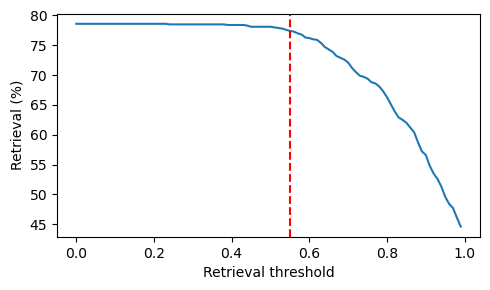

In [198]:


pubmed_retrieval_derivative = np.gradient(pubmed_retrieval)
max_index = argrelextrema(pubmed_retrieval_derivative, np.greater)

optimal_retrieval_score = np.array(retrieval_score_list)[max_index[0]][0]
print("Optimal threshold is ", optimal_retrieval_score)
print("Corresponding Retrieval (%) is ", 100*np.array(pubmed_retrieval)[max_index[0]][0])

# print(pubmed_retrieval_derivative[max_index[0]])
# print(np.array(pubmed_retrieval)[max_index[0]])
# print()


fig, ax1 = plt.subplots(figsize=(5, 3))

color = 'tab:blue'
ax1.set_xlabel('Retrieval threshold')
ax1.set_ylabel('Retrieval (%)')
ax1.plot(retrieval_score_list, 100*np.array(pubmed_retrieval), color=color)

line = ax1.axvline(x=optimal_retrieval_score, color='r', linestyle='--')
# plt.legend([line], ['Upper bound for retrieval'], loc="lower left")

fig.tight_layout()  
plt.show()


In [199]:

pubmed_bert_df_test = pd.read_csv(os.path.join(DATA_PATH, test_files[2]))


In [201]:
pubmed_bert_df_test[pubmed_bert_df_test.retrieval_score >= optimal_retrieval_score].shape[0]/pubmed_bert_df_test.shape[0]


0.8135818908122503

In [202]:
optimal_retrieval_score

0.55